In [1]:
%load_ext autoreload
%autoreload 2

from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import numpy as np

In [10]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osmDataDB
coll_areas = db.areas
coll_relations = db.relations
coll_nextBikeRaw = db.nextBikeRaw
coll_cities = db.cities
coll_stations = db.stationsInCities

In [8]:
from areas import areas_dict, countries_dict

In [11]:
records = [r for r in coll_cities.find()]
for r in records:
    r['geometry'] = shapely.geometry.shape(r['geometry'])
    del r['_id']
df_cities = gpd.GeoDataFrame([r for r in records])

In [12]:
for idx, row in df_cities.iterrows():
    stations = coll_stations.count_documents({ 'city_id': row.city_id })
    df_cities.loc[idx, 'stations'] = int(stations)
    df_cities.loc[idx, 'country'] = countries_dict[row.city]["country"]
    df_cities.loc[idx, 'country_code'] = countries_dict[row.city]["code"]

In [13]:
df_cities['city_label'] = df_cities[['city', 'country_code']].agg(', '.join, axis=1)

In [14]:
def getNearestStationDistance(city_id, st):
    nearest_station = coll_stations.find_one(
        { "geometry": { "$near": { "$geometry": st['geometry'], "$minDistance": 0.1 } }, "city_id": city_id }
    )
    dist = h3.point_dist(st['geometry']['coordinates'][::-1], nearest_station['geometry']['coordinates'][::-1], unit='m')
    # print(st['geometry']['coordinates'][::-1], nearest_station['geometry']['coordinates'][::-1], dist)
    return dist

distances = {}
for city_id in df_cities.city_id:
    distances[city_id] = []
    for station in tqdm(coll_stations.find({ "city_id": city_id }), desc=str(city_id)):
        distances[city_id].append(getNearestStationDistance(city_id, station))

1: 298it [00:00, 331.32it/s]
2: 502it [00:01, 347.07it/s]
3: 305it [00:00, 335.90it/s]
4: 193it [00:00, 306.15it/s]
5: 183it [00:00, 317.75it/s]
6: 95it [00:00, 340.75it/s]
7: 148it [00:00, 281.92it/s]
8: 349it [00:01, 298.80it/s]
9: 15it [00:00, 265.73it/s]
10: 159it [00:00, 302.24it/s]
11: 100it [00:00, 313.69it/s]
12: 22it [00:00, 329.37it/s]
13: 32it [00:00, 398.19it/s]
14: 51it [00:00, 289.36it/s]
15: 88it [00:00, 295.94it/s]
16: 47it [00:00, 226.85it/s]
17: 195it [00:00, 378.30it/s]
18: 34it [00:00, 211.34it/s]
19: 96it [00:00, 289.28it/s]
20: 96it [00:00, 363.22it/s]
21: 23it [00:00, 323.51it/s]
22: 22it [00:00, 259.83it/s]
23: 75it [00:00, 270.95it/s]
24: 112it [00:00, 297.79it/s]
25: 352it [00:01, 335.52it/s]
26: 118it [00:00, 428.75it/s]
27: 17it [00:00, 311.09it/s]
28: 92it [00:00, 371.58it/s]
29: 72it [00:00, 280.87it/s]
30: 789it [00:02, 373.91it/s]
31: 96it [00:00, 431.50it/s]
32: 422it [00:01, 371.45it/s]
33: 264it [00:00, 356.18it/s]
34: 96it [00:00, 336.29it/s]
35: 126

In [15]:
for idx, row in df_cities.iterrows():
    dists = distances[row.city_id]
    df_cities.loc[idx, 'average_nearest_distance'] = np.mean(dists)
    df_cities.loc[idx, 'std_nearest_distance'] = np.std(dists)
    df_cities.loc[idx, 'median_nearest_distance'] = np.median(dists)

In [16]:
df_cities_filtered = df_cities.loc[df_cities.stations >= 100]

In [17]:
df_cities_filtered

,city_id,city,osm_areas_ids,geometry,accepted,stations,country,country_code,city_label,average_nearest_distance,std_nearest_distance,median_nearest_distance
0,1,Antwerpen,[59518],"POLYGON ((4.21758 51.37389, 4.21826 51.37221, ...",True,298.0,Belgium,BE,"Antwerpen, BE",290.448723,126.622816,296.951839
1,2,Barcelona,[347950],"MULTIPOLYGON (((2.05250 41.42416, 2.05260 41.4...",True,502.0,Spain,ES,"Barcelona, ES",208.534175,108.739660,211.879947
2,3,Berlin,[62422],"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",True,305.0,Germany,DE,"Berlin, DE",398.765712,297.328318,327.409843
3,4,Bern,[1686344],"MULTIPOLYGON (((6.86148 47.16563, 6.86152 47.1...",True,193.0,Switzerland,CH,"Bern, CH",253.838127,198.180992,206.015676
4,5,Bordeaux,[1667452],"POLYGON ((-0.90492 44.80807, -0.89653 44.79124...",True,183.0,France,FR,"Bordeaux, FR",573.806912,459.588454,430.242235
6,7,Brno,[438171],"POLYGON ((16.42799 49.21667, 16.42882 49.21633...",True,148.0,Czech Republic,CZ,"Brno, CZ",290.611902,262.394612,187.595272
7,8,Bruxelles,[2404020],"POLYGON ((4.24377 50.81958, 4.24438 50.81954, ...",True,349.0,Belgium,BE,"Bruxelles, BE",383.474763,118.427501,374.641481
9,10,Budapest,[37244],"POLYGON ((18.92511 47.54414, 18.92979 47.54183...",True,159.0,Hungary,HU,"Budapest, HU",308.202857,133.356612,291.182607
10,11,Cardiff,[1625787],"MULTIPOLYGON (((-3.34377 51.52990, -3.34364 51...",True,100.0,United Kingdom,UK,"Cardiff, UK",475.501163,276.298314,433.746509
16,17,Dublin,[282800],"MULTIPOLYGON (((-6.54689 53.27948, -6.54462 53...",True,195.0,Ireland,IE,"Dublin, IE",217.736700,261.214090,157.567775


In [19]:
df_population = pd.read_excel('AnnualPopUrbanAggl-20210507075039.xlsx', sheet_name='Data')
df_population

,"Annual Population of Urban Agglomerations with 300,000 or more in 2018 (thousands)",Unnamed: 1,Unnamed: 2,Unnamed: 3
0,ISO 3166-1 numeric code,Location,Note,2018.0
1,900,World,NaN,NaN
2,908,Europe,NaN,NaN
3,923,Eastern Europe,NaN,NaN
4,112,Belarus,NaN,NaN
...,...,...,...,...
296,22600,Basel,NaN,552.0
297,22601,Bern,NaN,422.0
298,22602,Genève,NaN,599.0
299,22603,Lausanne,NaN,428.0


In [20]:
df_cities_filtered.city.values

array(['Antwerpen', 'Barcelona', 'Berlin', 'Bern', 'Bordeaux', 'Brno',
       'Bruxelles', 'Budapest', 'Cardiff', 'Dublin', 'Gothenburg',
       'Helsinki', 'Kyiv', 'London', 'Lyon', 'Madrid', 'Marseille',
       'Milan', 'Moscow', 'Munich', 'Nantes', 'Oslo', 'Ostrava', 'Paris',
       'Poznań', 'Prague', 'Seville', 'Toulouse', 'Valencia', 'Vienna',
       'Warszawa', 'Wrocław', 'Zaragoza', 'Zurich'], dtype=object)

In [21]:
iso_codes = {
    'Antwerpen': 20142,
    'Barcelona': 22525,
    'Berlin': 204296,
    'Bern': 22601,
    'Bordeaux': 20952,
    'Brno': 20881,
    'Bruxelles': 20144,
    'Budapest': 21138,
    'Cardiff': 22843,
    'Dublin': 21542,
    'Gothenburg': 22590,
    'Helsinki': 20937,
    'Kyiv': 22765,
    'London': 22860,
    'Lyon': 20972,
    'Madrid': 22549,
    'Marseille': 20973,
    'Milan': 21571,
    'Moscow': 22299,
    'Munich': 204371,
    'Nantes': 20981,
    'Oslo': 22028,
    'Paris': 20985,
    'Poznań': 22150,
    'Prague': 20887,
    'Seville': 22562,
    'Toulouse': 20997,
    'Valencia': 22567,
    'Vienna': 20107,
    'Warszawa': 22161,
    'Wrocław': 22164,
    'Zaragoza': 205149,
    'Zurich': 22606
}

In [22]:
# https://www.czso.cz/csu/czso/population-of-municipalities-1-january-2021

In [23]:
city_population = {
    'Ostrava': 290450
}

In [35]:
code_col = df_population.columns[0]
val_col = df_population.columns[-1]
for city, code in iso_codes.items():
    val = df_population.loc[df_population[code_col] == code][val_col].values[0]
    # print(city, code, int(val) * 1000)
    city_population[city] = int(val) * 1000

In [36]:
city_population

{'Ostrava': 290450,
 'Antwerpen': 1032000,
 'Barcelona': 5494000,
 'Berlin': 3552000,
 'Bern': 422000,
 'Bordeaux': 945000,
 'Brno': 378000,
 'Bruxelles': 2050000,
 'Budapest': 1759000,
 'Cardiff': 471000,
 'Dublin': 1201000,
 'Gothenburg': 596000,
 'Helsinki': 1279000,
 'Kyiv': 2957000,
 'London': 9046000,
 'Lyon': 1690000,
 'Madrid': 6497000,
 'Marseille': 1599000,
 'Milan': 3132000,
 'Moscow': 12410000,
 'Munich': 1504000,
 'Nantes': 662000,
 'Oslo': 1012000,
 'Paris': 10901000,
 'Poznań': 536000,
 'Prague': 1292000,
 'Seville': 707000,
 'Toulouse': 997000,
 'Valencia': 830000,
 'Vienna': 1901000,
 'Warszawa': 1768000,
 'Wrocław': 640000,
 'Zaragoza': 724000,
 'Zurich': 1371000}

In [37]:
for idx, row in df_cities_filtered.iterrows():
    df_cities_filtered.loc[idx, 'population'] = city_population[row.city]
    df_cities_filtered.loc[idx, 'population_per_station'] = city_population[row.city] / row.stations
    df_cities_filtered.loc[idx, 'stations_per_population'] = row.stations / city_population[row.city]

/home/raczeq/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/raczeq/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [38]:
df_cities_filtered

,city_id,city,osm_areas_ids,geometry,accepted,stations,country,country_code,city_label,average_nearest_distance,std_nearest_distance,median_nearest_distance,population,population_per_station,stations_per_population
0,1,Antwerpen,[59518],"POLYGON ((4.21758 51.37389, 4.21826 51.37221, ...",True,298.0,Belgium,BE,"Antwerpen, BE",290.448723,126.622816,296.951839,1032000.0,3463.087248,0.000289
1,2,Barcelona,[347950],"MULTIPOLYGON (((2.05250 41.42416, 2.05260 41.4...",True,502.0,Spain,ES,"Barcelona, ES",208.534175,108.739660,211.879947,5494000.0,10944.223108,0.000091
2,3,Berlin,[62422],"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",True,305.0,Germany,DE,"Berlin, DE",398.765712,297.328318,327.409843,3552000.0,11645.901639,0.000086
3,4,Bern,[1686344],"MULTIPOLYGON (((6.86148 47.16563, 6.86152 47.1...",True,193.0,Switzerland,CH,"Bern, CH",253.838127,198.180992,206.015676,422000.0,2186.528497,0.000457
4,5,Bordeaux,[1667452],"POLYGON ((-0.90492 44.80807, -0.89653 44.79124...",True,183.0,France,FR,"Bordeaux, FR",573.806912,459.588454,430.242235,945000.0,5163.934426,0.000194
6,7,Brno,[438171],"POLYGON ((16.42799 49.21667, 16.42882 49.21633...",True,148.0,Czech Republic,CZ,"Brno, CZ",290.611902,262.394612,187.595272,378000.0,2554.054054,0.000392
7,8,Bruxelles,[2404020],"POLYGON ((4.24377 50.81958, 4.24438 50.81954, ...",True,349.0,Belgium,BE,"Bruxelles, BE",383.474763,118.427501,374.641481,2050000.0,5873.925501,0.000170
9,10,Budapest,[37244],"POLYGON ((18.92511 47.54414, 18.92979 47.54183...",True,159.0,Hungary,HU,"Budapest, HU",308.202857,133.356612,291.182607,1759000.0,11062.893082,0.000090
10,11,Cardiff,[1625787],"MULTIPOLYGON (((-3.34377 51.52990, -3.34364 51...",True,100.0,United Kingdom,UK,"Cardiff, UK",475.501163,276.298314,433.746509,471000.0,4710.000000,0.000212
16,17,Dublin,[282800],"MULTIPOLYGON (((-6.54689 53.27948, -6.54462 53...",True,195.0,Ireland,IE,"Dublin, IE",217.736700,261.214090,157.567775,1201000.0,6158.974359,0.000162


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_style("whitegrid")
# sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

<ipython-input-65-107bcf2b9c05>:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-65-107bcf2b9c05>:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('stations_per_city_all.pdf', dpi=300, format='pdf', bbox_inches='tight')
/home/raczeq/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


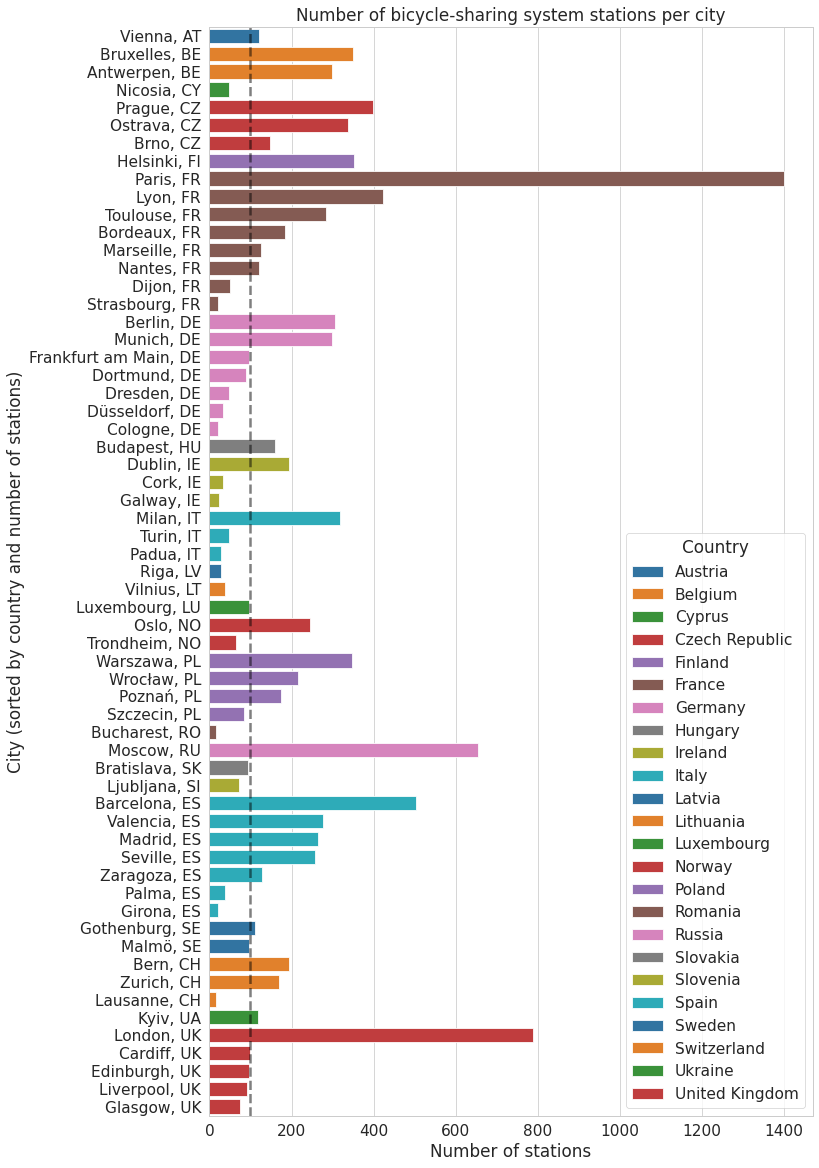

In [65]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

# sns.set(font_scale = 1.25)

g = sns.barplot(
    data=df_cities,
    x="stations", y="city_label",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities.sort_values(['country', 'stations'], ascending=[True, False]).city_label,
    hue="country", dodge=False,
    hue_order=countries_list,
    palette = sns.color_palette("tab10")
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

g.axvline(100, ls='--', c='k', alpha=0.5)
# g.set_axis_labels("Metric value", "Density")
# g.set_titles("{row_name}\nMetric: {col_name}")
# g.fig.subplots_adjust(wspace=0.1, hspace=0.15)
# g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
# g.fig.suptitle(f'Metrics distribution for multiple neighbour embedding methods\n[City: Warsaw, Hex resolution: {res}, Validation dataset]')

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Number of stations")
plt.ylabel("City (sorted by country and number of stations)")
plt.title("Number of bicycle-sharing system stations per city")
plt.legend(title='Country')

# plt.xlabel("Number of stations", size=20)
# plt.ylabel("City (sorted by country and number of stations)", size=20)
# plt.title("Number of bicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_per_city_all.pdf', dpi=300, format='pdf', bbox_inches='tight')

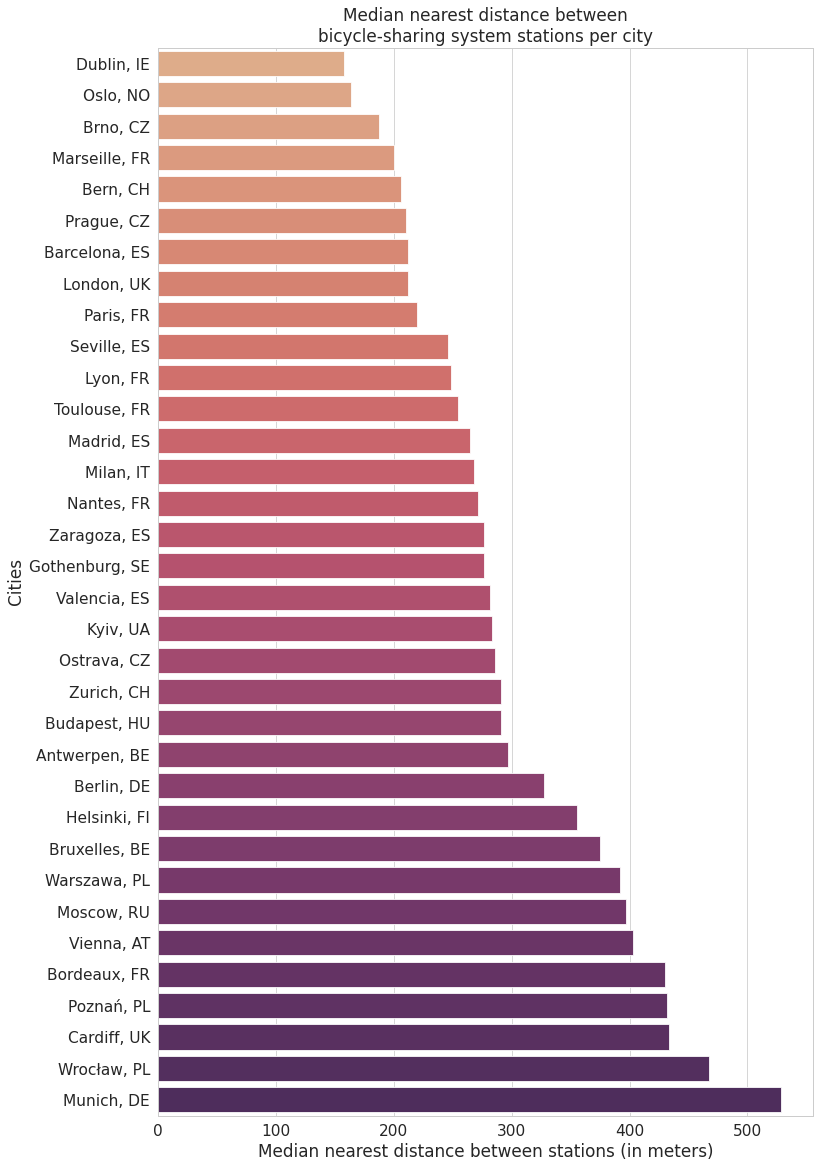

In [50]:
# fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities_filtered.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

g = sns.barplot(
    data=df_cities_filtered,
    x="median_nearest_distance", y="city_label",
    palette="flare",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities_filtered.sort_values(['median_nearest_distance'], ascending=[True]).city_label,
    # hue="country", 
    dodge=False,
    # hue_order=countries_list,
    # palette = sns.color_palette("viridis"),
    # facet_kws={"legend_out": True}
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

# g.axvline(530, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Median nearest distance between stations (in meters)")
plt.ylabel("Cities")
plt.title("Median nearest distance between\nbicycle-sharing system stations per city")
# g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.xlabel("Median nearest distance between stations (in meters)", size=20)
# plt.ylabel("Cities (sorted by country and median)", size=20)
# plt.title("Median nearest distance between\nbicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_median_distance_per_city_accpeted_sorted_values.pdf', dpi=300, format='pdf', bbox_inches='tight')

No handles with labels found to put in legend.


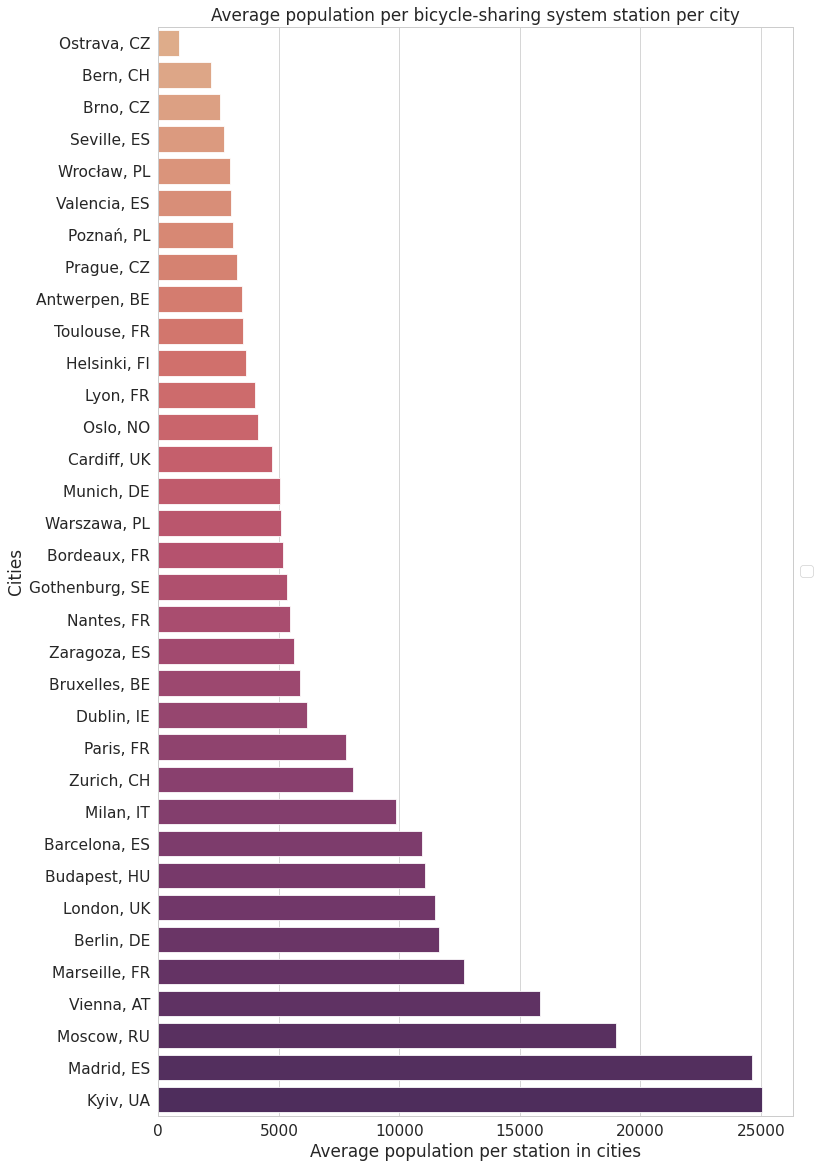

In [51]:
fig = plt.figure(figsize=(11.69,16.53))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 2.5})

countries_list = df_cities_filtered.sort_values('country', ascending=True).country.unique()
# my_cmap = ListedColormap(sequential_hcl(n = len(countries_list), name = "Light Grays").colors())

g = sns.barplot(
    data=df_cities_filtered,
    x="population_per_station", y="city_label",
    palette = "flare",
    # order=df_cities.sort_values('stations', ascending=False).city_label,
    order=df_cities_filtered.sort_values(['population_per_station'], ascending=[True]).city_label,
    # hue="country",
    dodge=False,
    # hue_order=countries_list,
    
    # facet_kws={"legend_out": True}
    # palette = sns.color_palette(sequential_hcl(n = len(countries_list), name = "Pastel 1").colors())
    # cmap = sequential_hcl(n = len(countries_list), name = "Grays").cmap()
)

# g.axvline(530, ls='--', c='k', alpha=0.5)

# g.set_yticklabels(g.get_yticks(), size = 18)

plt.xlabel("Average population per station in cities")
plt.ylabel("Cities")
plt.title("Average population per bicycle-sharing system station per city")
# g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.xlabel("Median nearest distance between stations (in mflareeters)", size=20)
# plt.ylabel("Cities (sorted by country and median)", size=20)
# plt.title("Median nearest distance between\nbicycle-sharing system stations per city", size=20)
plt.tight_layout()

fig.savefig('stations_population_density_distance_per_city_accpeted_sorted_values.pdf', dpi=300, format='pdf', bbox_inches='tight')

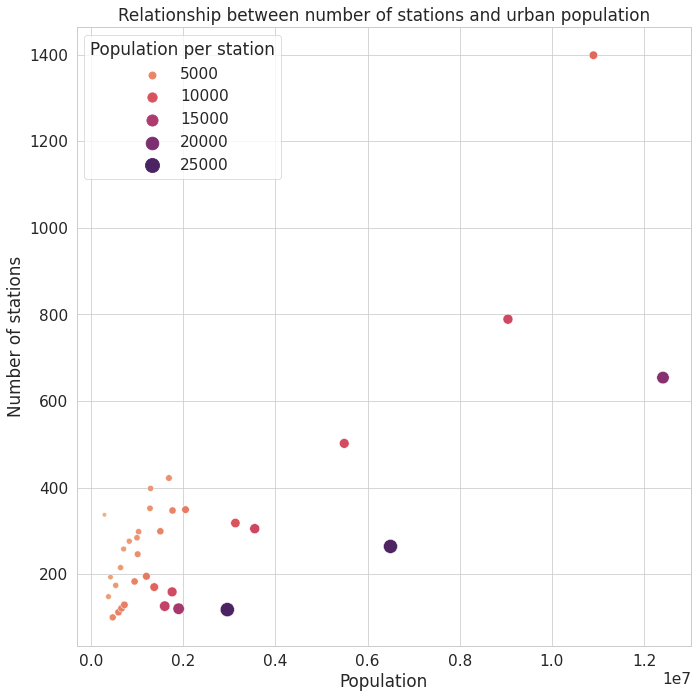

In [64]:
fig = plt.figure(figsize=(10,10))
g = sns.scatterplot(
    data=df_cities_filtered, x="population", y="stations",
    palette="flare", size="population_per_station", hue="population_per_station",
    sizes=(20, 200))
# plt.xlabel("Average population per station in cities")
# g._legend.set_title('Population per station')
# leg = g.axes.flat[0].get_legend()
# # new_title = 'My title'
# leg.set_title('Population per station')
plt.legend(title='Population per station')
plt.xlabel("Population")
plt.ylabel("Number of stations")
plt.title("Relationship between number of stations and urban population")

plt.tight_layout()
fig.savefig('stations_population_scatterplot.pdf', dpi=300, format='pdf', bbox_inches='tight')